In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# Imports
import os
import pandas as pd
from dw_events.temperature_compensation.particle_filter import ParticleFilter
from dw_events.data.make_dataset import DataGetter
from dw_events.data.utils import make_dt_list, get_dataframe_str_subset
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [7]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
data_path = \
    "_".join(
        [
            "../../data/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
datagetter = DataGetter(start, end)
try:
    strain_data = pd.read_parquet(data_path)
    datagetter.merged_signals = strain_data
except:
    strain_data = datagetter.get_strain_data(destination = "../../data/raw/SCB_ALM")
    #strain_data.to_parquet(data_path)

In [8]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
bottom_temperature_data = temperature_data.filter(regex="_B")

In [187]:
# Get strain line data BCN
TCN_signals = datagetter.get_dataframe_str_subset('TCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
tcn_temperature_data = temperature_data.filter(regex="TCN")

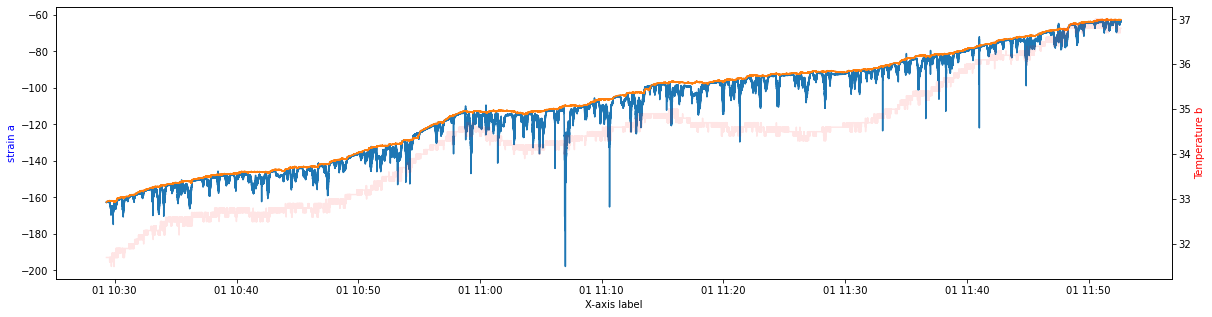

In [345]:
start = 900100
stop = start + 100000
#stop = 2000000
sensor = 3
Tb = tcn_temperature_data
strain_signal = TCN_signals
delta_Tb = Tb - Tb.shift(int(1))
loading = 'compression'

measurements = pd.DataFrame(
    {
        strain_signal.columns[sensor]: strain_signal.iloc[start:stop, sensor].values
    },
    index = strain_signal.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 500,
        r_measurement_noise = 1e5,
        q_process_noise = np.array([2e-2, 1e-1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values, loading = loading)
filtered_data = pd.DataFrame(
    {
        'predictions_' + measurements.columns[0]: pf.predictions
    },
    index = measurements.index
)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'], color='red', alpha = 0.1)
ax1.plot(measurements)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean = np.array([measurements[0], 0])


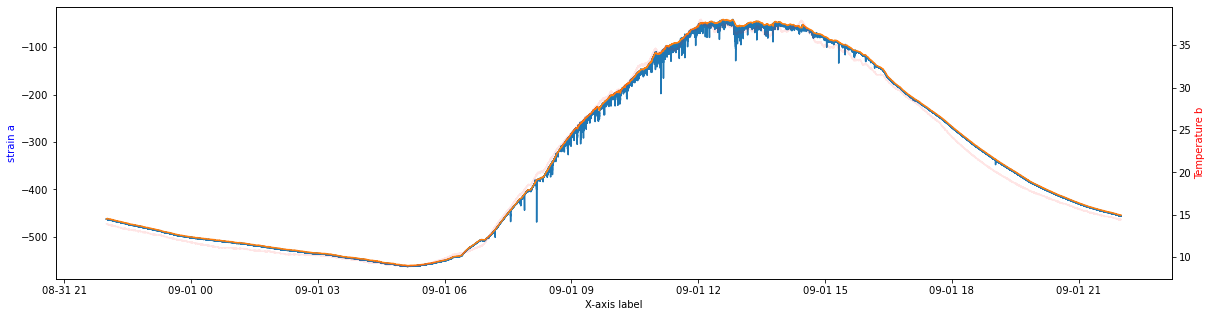

In [899]:
start = 900100
start = 1600000
stop = start + 10000
start = 120
stop = 2000000
sensor = 3
Tb = tcn_temperature_data
strain_signal = TCN_signals
delta_Tb = (Tb - Tb.shift(int(20*60)))/60
loading = 'compression'

measurements = pd.DataFrame(
    {
        strain_signal.columns[sensor]: strain_signal.iloc[start:stop, sensor].values
    },
    index = strain_signal.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

measurements = measurements.resample('1s').mean().dropna()
inputs = inputs.dropna().resample('1s').mean().dropna().loc[measurements.index]

pf = \
    ParticleFilter(
        num_particles = 2000,
        r_measurement_noise = 1e3,
        q_process_noise = np.array([2e-1, 1e-1]),
        scale = 1,
        loc = -0.5
    )

filtered_data = pf.filter(measurements.values, inputs.values, loading = loading)
filtered_data = pd.DataFrame(
    {
        'predictions_' + measurements.columns[0]: pf.predictions
    },
    index = measurements.index
)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'], color='red', alpha = 0.1)
ax1.plot(strain_signal.iloc[start:stop,sensor])
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

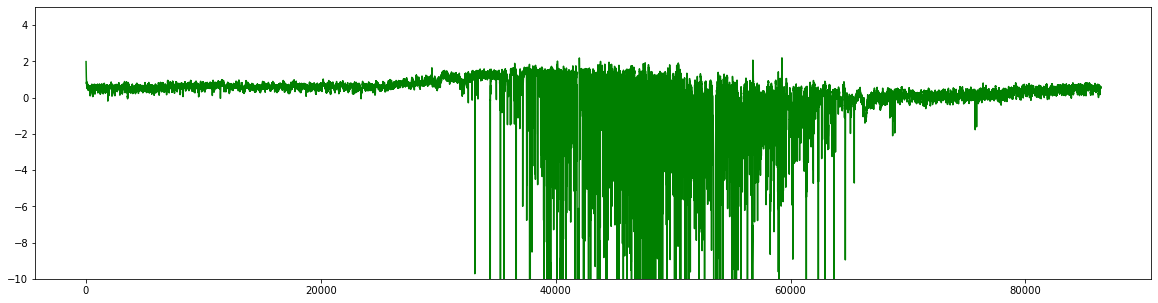

In [900]:
plt.figure(figsize=(20,5))
plt.plot(measurements.values - filtered_data.reindex(measurements.index).interpolate(method='linear').values + 2, color = 'green')
plt.ylim(-10, 5)
plt.show()

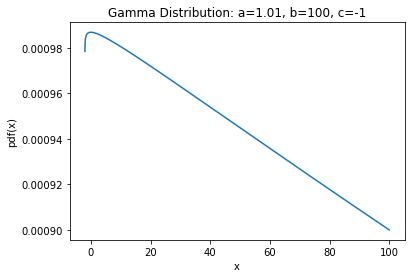

In [840]:
fig, ax = plt.subplots()

x = np.linspace(-1.99, 100, 10000)
pdf = pf.expon_distr.pdf(x)

ax.plot(x, pdf)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title(f'Gamma Distribution: a={a}, b={b}, c={c}')

plt.show()

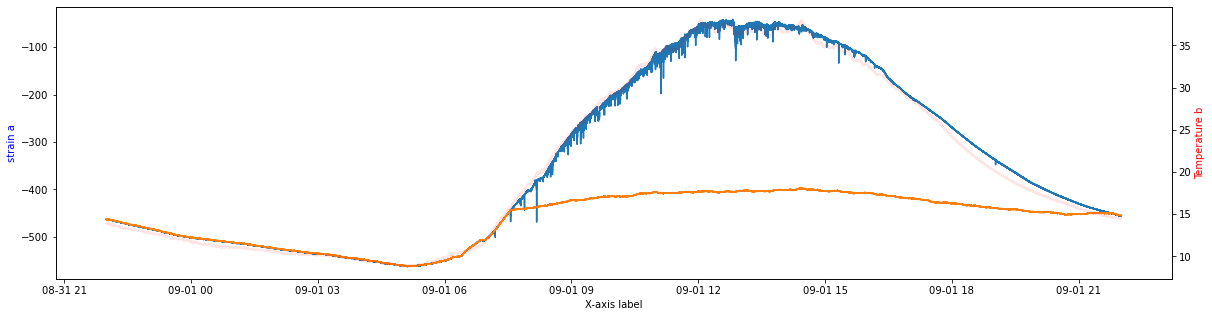

In [627]:
start = 1601000
start = 900100
stop = start + 20000
start = 10
stop = 2000000
sensor = 3
Tb = tcn_temperature_data
strain_signal = TCN_signals
delta_Tb = Tb - Tb.shift(int(2))
loading = 'compression'

measurements = pd.DataFrame(
    {
        strain_signal.columns[sensor]: strain_signal.iloc[start:stop, sensor].values
    },
    index = strain_signal.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 1000,
        r_measurement_noise = 2e4,
        q_process_noise = np.array([1e-2, 1e-1]),
        scale = 1e-4
    )

filtered_data = pf.filter(measurements.values, inputs.values, loading = loading)
filtered_data = pd.DataFrame(
    {
        'predictions_' + measurements.columns[0]: pf.predictions
    },
    index = measurements.index
)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'], color='red', alpha = 0.1)
ax1.plot(measurements)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

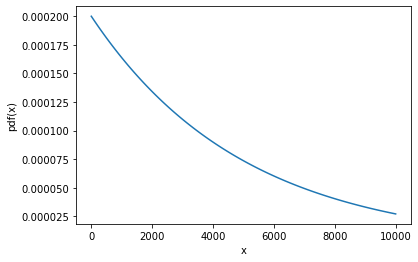

In [757]:
x = np.linspace(0, 10000, 100)

# Define the parameters of the gamma distribution
a = 2   # shape parameter
b = 100   # scale parameter
c = 0  # location parameter
distr = sp.stats.expon(0.1, b)
distr = sp.stats.expon(-0.3, 5e3)
pdf = distr.pdf(x)
# Plot the probability density function
fig, ax = plt.subplots()
ax.plot(x, pdf)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')

plt.show()

1.01


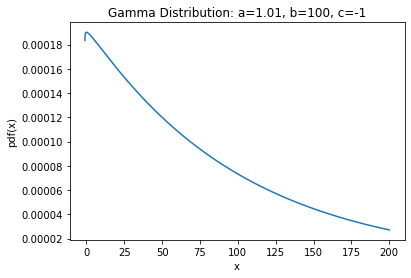

In [763]:
import scipy as sp


# Define the parameters of the gamma distribution
b = 100   # scale parameter
c = -1  # location parameter
a = 1 - c/b  # shape parameter
x = np.linspace(c+0.01, 200, 10000)
print(a)
distr = sp.stats.gamma(a, c, b)
distr = sp.stats.gamma(a, scale=b, loc = c)
pdf = distr.pdf(x)/50
# Plot the probability density function
fig, ax = plt.subplots()
ax.plot(x, pdf)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.set_title(f'Gamma Distribution: a={a}, b={b}, c={c}')

plt.show()

In [750]:
start = 10
stop = start + 100000
stop = 2000000
sensor = 3
Tb = tcn_temperature_data
strain_signal = TCN_signals
delta_Tb = Tb - Tb.shift(int(1))
loading = 'compression'

measurements = pd.DataFrame(
    {
        strain_signal.columns[sensor]: strain_signal.iloc[start:stop, sensor].values
    },
    index = strain_signal.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 500,
        r_measurement_noise = 1e5,
        q_process_noise = np.array([2e-2, 1e-1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values, loading = loading)
filtered_data = pd.DataFrame(
    {
        'predictions_' + measurements.columns[0]: pf.predictions
    },
    index = measurements.index
)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'], color='red', alpha = 0.1)
ax1.plot(measurements)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean = np.array([measurements[0], 0])


KeyboardInterrupt: 

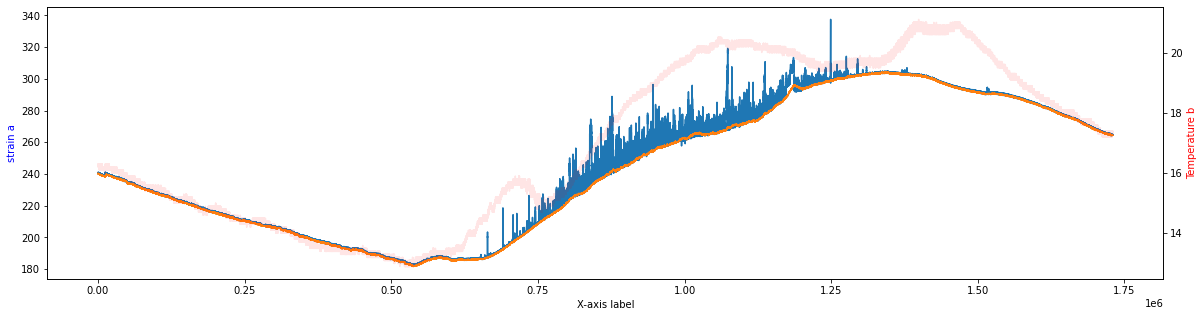

In [273]:
start = 10
stop = len(BCN_signals)
sensor = 3
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(int(1))

measurements = pd.DataFrame(
    {
        BCN_signals.columns[sensor]: BCN_signals.iloc[start:stop, sensor].values
    },
    index = BCN_signals.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 100,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'].values, color='red', alpha = 0.1)
ax1.plot(measurements.values)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


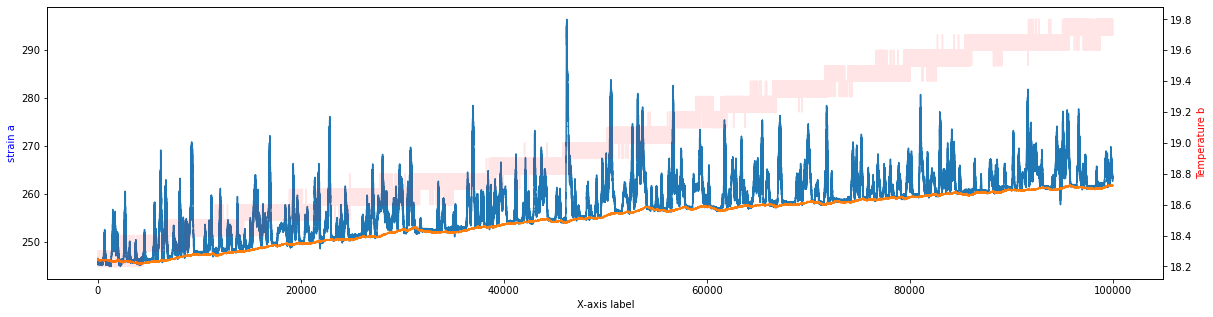

In [260]:
start = 900000
stop = 1000000
sensor = 3
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(int(1))

measurements = pd.DataFrame(
    {
        BCN_signals.columns[sensor]: BCN_signals.iloc[start:stop, sensor].values
    },
    index = BCN_signals.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 100,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'].values, color='red', alpha = 0.1)
ax1.plot(measurements.values)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  def filter(


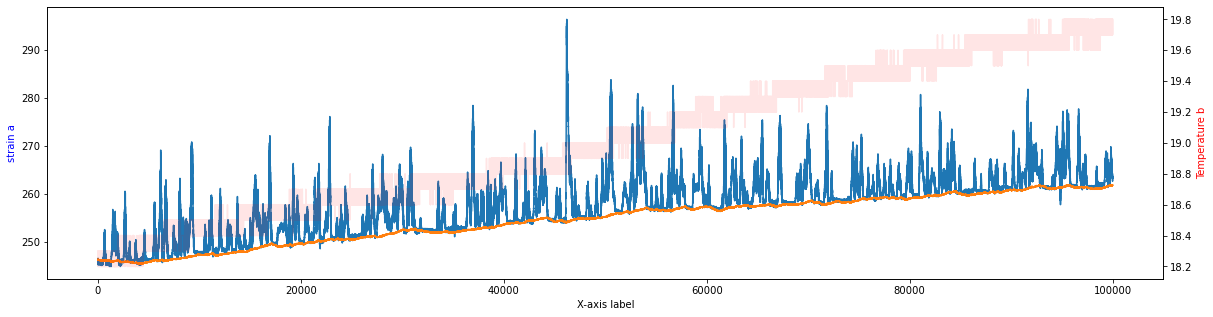

In [246]:
start = 900000
stop = 1000000
sensor = 3
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(int(1))

measurements = pd.DataFrame(
    {
        BCN_signals.columns[sensor]: BCN_signals.iloc[start:stop, sensor].values
    },
    index = BCN_signals.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 100,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'].values, color='red', alpha = 0.1)
ax1.plot(measurements.values)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean = np.array([measurements[0], 0])


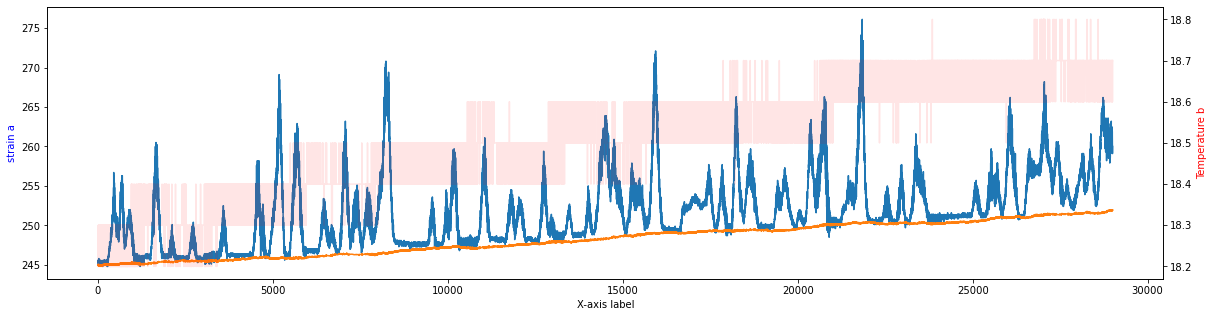

In [182]:
pf = \
    ParticleFilter(
        num_particles = 50,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'].values, color='red', alpha = 0.1)
ax1.plot(measurements.values)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\particle_filter.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean = np.array([measurements[0], 0])


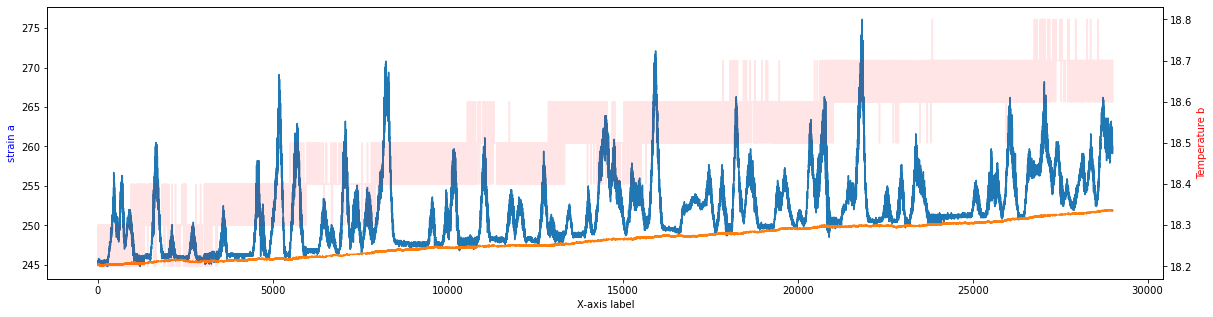

In [179]:
pf = \
    ParticleFilter(
        num_particles = 50,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'].values, color='red', alpha = 0.1)
ax1.plot(measurements.values)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()

In [8]:
import numpy as np

def generate_particles(x, y, num_particles, sigma_x, sigma_y):
    particles = np.zeros((num_particles, len(x)))
    for i in range(num_particles):
        particles[i] = np.sin(x) + np.random.normal(0, sigma_x, len(x))
    return particles

def evaluate_particles(particles, y, sigma_y):
    num_particles = particles.shape[0]
    weights = np.zeros(num_particles)
    for i in range(num_particles):
        weights[i] = np.exp(-np.sum((particles[i] - y) ** 2) / (2 * sigma_y ** 2))
    weights /= np.sum(weights)
    return weights

def resample_particles(particles, weights):
    num_particles = particles.shape[0]
    new_particles = np.zeros_like(particles)
    cumulative_weights = np.cumsum(weights)
    index = np.random.rand() / num_particles
    i, j = 0, 0
    while i < num_particles:
        if index > cumulative_weights[j]:
            j += 1
        else:
            new_particles[i] = particles[j]
            i += 1
            index += 1 / num_particles
    return new_particles

def denoise_signal(x, y, num_particles, sigma_x, sigma_y):
    particles = generate_particles(x, y, num_particles, sigma_x, sigma_y)
    weights = evaluate_particles(particles, y, sigma_y)
    for i in range(100):
        particles = resample_particles(particles, weights)
        particles = generate_particles(x, y, num_particles, sigma_x, sigma_y)
        weights = evaluate_particles(particles, y, sigma_y)
    return np.mean(particles, axis=0)

In [9]:
start = 990000
stop = 1000000

x = BCN_signals.iloc[start:stop].reset_index().index
y = BCN_signals.iloc[start:stop,3].values
num_particles = 10
sigma_x = 1
sigma_y = 1e-5

denoised_signal = denoise_signal(x, y, num_particles, sigma_x, sigma_y)

C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)
C:\Users\Max\AppData\Local\Temp\ipykernel_18536\984929061.py:14: RuntimeWarning: invalid value

In [340]:
strain_data

,SCB_ALM_WN_FBG_HOR001_45_nr1,SCB_ALM_WN_FBG_HOR001_45_nr2,SCB_ALM_WN_FBG_HOR003_45_nr3,SCB_ALM_WN_FBG_HOR005_45_nr4,SCB_ALM_WN_FBG_HOR007_45_nr5,SCB_ALM_WN_FBG_HOR009_min45_nr6,SCB_ALM_WN_FBG_HOR011_min45_nr7,SCB_ALM_WN_FBG_HOR013_min45_nr8,SCB_ALM_WN_FBG_HOR015_min45_nr9,SCB_ALM_WN_FBG_HOR015_min45_nr10,...,SCB_ALM_BN_FBG_HOR014_0_nr7,SCB_ALM_BCN_FBG_HOR002_0_nr1,SCB_ALM_BCN_FBG_HOR004_0_nr2,SCB_ALM_BCN_FBG_HOR006_0_nr3,SCB_ALM_BCN_FBG_HOR008_0_nr4,SCB_ALM_BCN_FBG_HOR010_0_nr5,SCB_ALM_BCN_FBG_HOR012_0_nr6,SCB_ALM_BCN_FBG_HOR014_0_nr7,SCB_ALM_TCS_TFBG_HOR013,SCB_ALM_WS_TFBG_HOR013
time,,,,,,,,,,,,,,,,,,,,,
2022-08-31 22:00:00+00:00,228.7,308.8,245.5,242.7,203.6,85.5,122.0,190.5,297.5,286.9,...,193.0,220.8,201.3,225.2,240.4,237.0,255.6,218.8,12.4,19.1
2022-08-31 22:00:00.050000+00:00,228.9,308.8,245.3,242.7,203.6,85.5,122.0,190.5,297.3,286.9,...,193.0,220.8,201.3,224.9,240.4,237.0,255.4,218.9,12.5,19.2
2022-08-31 22:00:00.100000+00:00,228.7,308.8,245.3,242.5,203.4,85.5,122.0,190.4,297.1,286.9,...,192.7,220.8,201.0,224.9,240.4,237.0,255.6,218.6,12.4,19.2
2022-08-31 22:00:00.150000+00:00,228.7,309.1,245.3,242.7,203.6,85.3,122.0,190.4,297.1,286.9,...,193.0,220.8,201.1,224.7,240.2,237.0,255.3,218.8,12.4,19.2
2022-08-31 22:00:00.200000+00:00,229.0,308.8,245.5,242.4,203.6,85.3,122.1,190.4,297.3,286.6,...,192.8,220.8,201.3,225.2,240.2,237.0,255.6,218.8,12.4,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01 21:59:59.750000+00:00,237.6,310.8,245.8,241.8,204.8,87.6,124.4,190.2,301.0,297.9,...,213.5,239.9,221.8,247.1,264.6,254.0,278.6,236.4,12.5,19.0
2022-09-01 21:59:59.800000+00:00,237.3,310.0,245.6,241.6,204.5,87.6,124.4,190.1,300.8,297.8,...,213.5,239.9,221.7,247.3,264.8,254.2,278.6,236.4,12.5,19.0
2022-09-01 21:59:59.850000+00:00,237.6,310.3,245.6,241.8,204.5,87.4,124.4,190.4,301.3,297.6,...,213.5,240.2,221.8,247.4,264.6,254.0,278.9,236.1,12.5,19.0


# Particle filter for bcn sensors

In [ ]:
start = 1
stop = len(BCN_signals)
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(int(1))

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)
for sensor in range(len(BCN_signals.columns)):
    

In [ ]:
start = 10
stop = len(BCN_signals)
sensor = 3
Tb = bottom_temperature_data
delta_Tb = Tb - Tb.shift(int(1))

measurements = pd.DataFrame(
    {
        BCN_signals.columns[sensor]: BCN_signals.iloc[start:stop, sensor].values
    },
    index = BCN_signals.index[start:stop])

inputs = pd.DataFrame(
    {
        'Tb': Tb.iloc[start:stop].values[:,0],
        'delta_Tb': delta_Tb.iloc[start:stop].values[:,0]
    }, index = measurements.index)

pf = \
    ParticleFilter(
        num_particles = 100,
        r_measurement_noise = 1e2,
        q_process_noise = np.array([5e-3, 1]),
        scale = 1e-3
    )

filtered_data = pf.filter(measurements.values, inputs.values)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()

# Plot the data on the respective axes
ax2.plot(inputs['Tb'].values, color='red', alpha = 0.1)
ax1.plot(measurements.values)
ax1.plot(filtered_data)

# Set the labels and limits for the axes
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('strain a', color='blue')
ax2.set_ylabel('Temperature b', color='red')

# Show the plot
plt.show()